In [1]:
## Importing standards libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
#import torch


## Importing libraries for the Gaussian Mixture Model

from scipy.stats import multivariate_normal
from scipy.stats import norm
import seaborn as sns


## Convergence metrics

from scipy.stats import wasserstein_distance
from scipy.stats import entropy # KL-divergence


## Import functions for the experiment : 

from experiment_functions import *
from IPLA_Exp_Functions import *
from IPLA_functions_MMLE_V2 import *


### Setting of the Experiment

In this Notebook, we consider the same setting as previously with the same Latent Variable Model :


- $\mathbf{y} = \theta^{*}\mathbf{x} + \mathbf{z}$ where:
- $\mathbf{y} \in \mathbb{R}$ is the observed data,
- $\theta^{*} \in \mathbb{R}^{2}$ is the "ground truth" parameter that links the latent variables and the observed data.

To generate $\mathbf{y}$, the observed data, we first draw $x^{*} \sim p_{0}$ and set $\mathbf{y} := \theta^{*}x + \mathbf{z}$, where $\mathbf{z} \sim \mathcal{N}(0, \sigma_y^{2})$ 

For a given dimension $d_x$, we consider the prior distribution $p_0$, which is a mixture of 25 Gaussian random variables. The components have mean $\mu_{i,j} := (8i, 8j, \ldots, 8i, 8j) \in \mathbb{R}^{d_x}$ for $(i, j) \in \{-2, -1, 0, 1, 2\}^2$ and unit variance. We have set the associated unnormalized weights $\omega_{i,j} = 1.0$. This choice of Parametric Model is convenient because it allows the Posterior Distribution to stay in the same parametric family of distribution : it is a Gaussian Mixture. 

The joint density of the variables, $ p_\theta(x, y) $, is given by : $ p_\theta(x, y) = p_\theta(y \mid x) p_{0}(x) $, where : 
- $ p_\theta(y \mid x) = \mathcal{N}(y \mid \theta^{*}x, \sigma_y^2)$
- $ p_{0}(x) = \frac{1}{K} \sum_{k=1}^K \mathcal{N}(x \mid \mu_k, I) $

But here, we would like to estimate the Maximum Marginal Likelihood of the model given one observations $y_{obs} \in \mathbb{R}$, which correspond to : 

\begin{equation}
\theta^\ast \in \arg \max_{\theta \in \mathbb{R}^{d_\theta}} \log p_\theta(y),
\end{equation}

In order to do that, we implement several algorithms and compare their efficiency through different examples : 
- Particle Gradient Descent
- Interacting Particle Langevin Algorithm from the "[Interacting Particle Langevin Algorithm for Maximum Marginal
Likelihood Estimation](https://arxiv.org/pdf/2303.13429)"
- Interacting Particle Langevin Algorithm with Dilation Path, inspired from the idea of a convolutional path for ULA in "[A Practical Diffusion Path for Sampling](https://arxiv.org/abs/2406.14040)"

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
First, we have to generate the observation $y_{obs}$ as mentionned in the article. For that we generate : 
- Parameters of the prior distribution
- A sample from the prior distribution to initialize the position of the particles
- Chose the 'true' parameter &\theta& of the model
- Generate the observation $y_{obs}$ 

Shape of means array: (25, 10)
Unit Covariance Matrix: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Weights vector : [0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04]


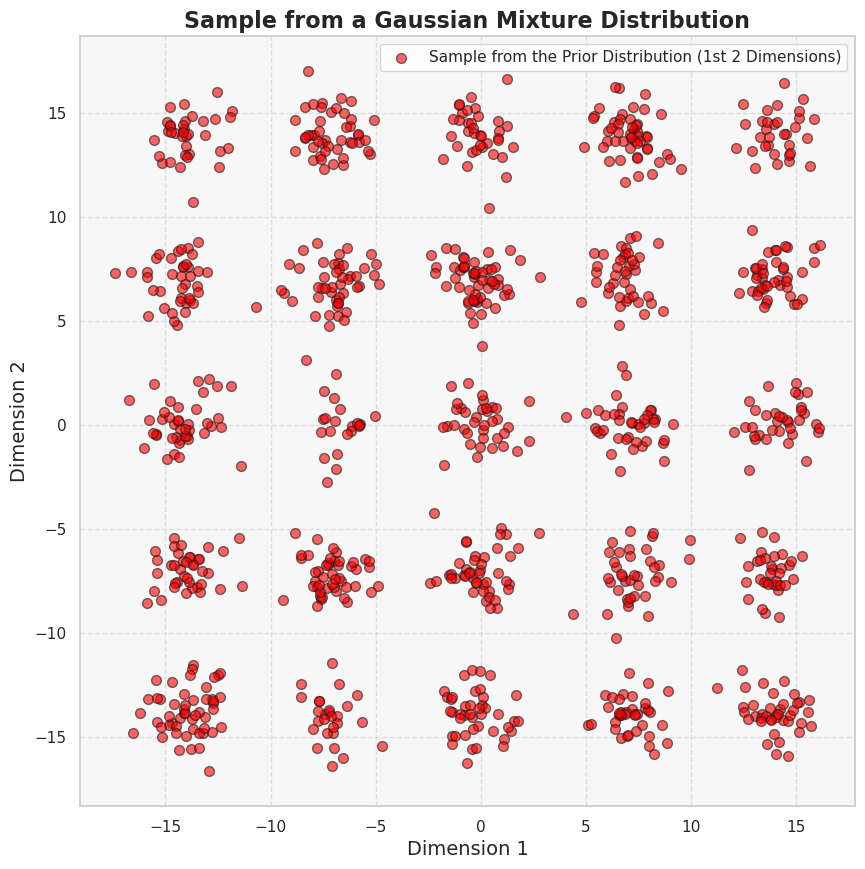

In [2]:
params_prior = gen_prior_param(10, 15)

x_start = sample_prior_dx(1000, params_prior[0], params_prior[1], params_prior[2])
plot_sample_dx(x_start, desc_sample_1 = 'Sample from the Prior Distribution (1st 2 Dimensions)')

In [443]:
x_star = sample_prior_dx(1, params_prior[0], params_prior[1], params_prior[2])

#theta_star = np.random.uniform(0, 1, 10)
theta_star = np.tile([-1, 1], 5)

y_obs_dx = generate_obs_dx(x_star, theta_star, 0.1)
y_obs_dx

array([-3.11514889])

Here we simply plot the true posterior Distribution of the model given the observation and $\theta$

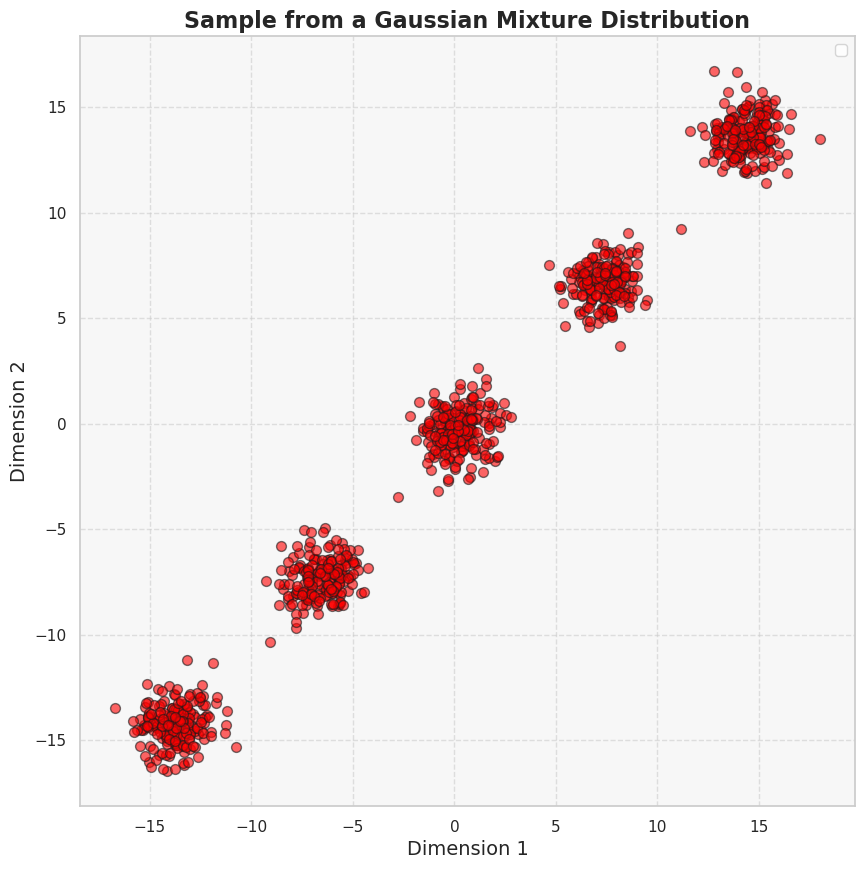

In [444]:
centers_posteriori, covariances_posteriori, weights_posteriori = post_params_dx(theta_star, 0.1, params_prior[0], params_prior[1], params_prior[2], y_obs_dx)

sample_post = sample_prior_dx(1000, centers_posteriori, covariances_posteriori, weights_posteriori)

plot_sample_dx(sample_post)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Here is the function that computes the gradient our the log-density of the joint distribution, w.r.t parameter theta :

The joint density of the variables, $ p_\theta(x, y) $, is given by : $ p_\theta(x, y) = p_\theta(y \mid x) p_{0}(x) $. We are able to compute the gradient of $ p_\theta(x, y) $ with respect to the parameter $\theta$ (CHECK "-"):

\begin{equation}
- \nabla_{\theta} \log p_{\theta}(x, y) = \frac{1}{\sigma_y^2} (y - \theta x) x^T
\end{equation}

In [7]:
def grad_theta_GM(x_t, theta_t, y_obs, sigma_y):
    """
    This function can compute the gradient of the log density of our LVM (potential function), with respect to the parameters theta. 
    """

    return (-1 / sigma_y**2) * (y_obs - np.dot(x_t, theta_t.T))[:, np.newaxis] * x_t

### Particle Gradient Descent 

**Inputs**: 
- Step size $ h $
- Number of steps $ K $
- Number of particles $ N $
- Initial particles $ X_0^1, \dots, X_0^N $
- Initial parameter estimates $ \theta_0 $

**Algorithm**:

1. For $ k = 0, \dots, K-1 $ do:
   
   a. **Update the parameter estimates**:
   
      $
      \theta_{k+1} = \theta_k + \frac{h}{N} \sum_{n=1}^{N} \nabla_{\theta} \ell(\theta_k, X_k^n)
      $
   
   b. **Update the particles**: for all $ n = 1, \dots, N $,

      $
      X_{k+1}^n = X_k^n + h \nabla_{x} \ell(\theta_k, X_k^n) + \sqrt{2h} W_k^n
      $
      
      where $ W_k^1, \dots, W_k^N $ are i.i.d. random variables drawn from $ N(0, \mathbf{I}_{D_x}) $.

5. Return $ (\theta_k, q_k := \frac{1}{N} \sum_{n=1}^{N} \delta_{X_k^n})_{k=0}^{K} $


In [95]:

def PGD_dx(nb_particles, nb_iter, step_size, centers_prior, covariances_prior, weights_prior, theta_0, sigma_y, y_obs, plot = False, plot_true_theta = None) : 
    """
    This function executes the Particle Gradient Descent in the context of our experiment. Given :
    - The number of particles
    - The number of iterations
    - The step size
    - Parameters of the prior distribution
    - The observed data point "y"
    - The initializing theta_0
    """

    theta_t = theta_0

    dx = theta_0.shape[0]

    sample = sample_prior_dx(nb_particles, centers_prior, covariances_prior, weights_prior)

    time_SDE = 0

    theta_traj = np.zeros((nb_iter, dx))

    for i in tqdm(range(nb_iter)) : 

        #We don't need to compute the parameters of the posteriori distribution given the updated theta because we use another formula
        #centers_post, covariances_post, weights_post = post_params(theta_t, sigma_y, centers_prior, covariances_prior, weights_prior)

        time_SDE += step_size

        ## on prend le gradient selon x de la posterior actualisée avec theta_t et qui est aussi une mixture Gaussienne
        grad = ((1/sigma_y**2) * theta_t[:, np.newaxis] * (y_obs - np.dot(theta_t, sample.T))).T 

        grad += grad_multimodal_opti(sample, weights_prior, centers_prior, covariances_prior) 

        grad_update = step_size * grad
        
        #Noise
        noise =  np.sqrt(2 * step_size) * np.random.randn(nb_particles, dx)

        sample += grad_update + noise #Warning sign

        #MAJ THETA we need a fct that compute gradient of the potential wrt to theta

        grad_theta = grad_theta_GM(sample, theta_t, y_obs, sigma_y) #renvoie un vecteur avec tous les gradients

        grad_theta_update = np.sum(grad_theta, axis = 0) ## ON MULTIPLIE CHAQUE PARTICLE A SON PAS SPECIFIQUE

        theta_t = theta_t - (step_size / nb_particles) * grad_theta_update 

        theta_traj[i] = theta_t

        if np.sum(np.isnan(sample)) // dx > 850:

            print('Too many NaN in the sample')
            
            return sample, theta_t, theta_traj

    if plot : 

        centers_post, covariances_post, weights_post = post_params_dx(plot_true_theta, sigma_y, centers_prior, covariances_prior, weights_prior, y_obs)
        
        sample_post = sample_prior_dx(1000, centers_post, covariances_post, weights_post)
        
        plot_sample_dx(sample, "PDG Sample", sample_post, "True Posterior Sample")

        #plot
        plt.figure(figsize=(10, 8))

        plt.plot(theta_traj[:, 0], theta_traj[:, 1], 'o-', markersize=4, label='Theta Trajectory')

        for i in range(1, len(theta_traj)):

            plt.arrow(theta_traj[i-1, 0], theta_traj[i-1, 1], 
                    theta_traj[i, 0] - theta_traj[i-1, 0], 
                    theta_traj[i, 1] - theta_traj[i-1, 1], 
                    head_width=0.05, head_length=0.1, fc='blue', ec='blue')
            
        plt.scatter(plot_true_theta[0], plot_true_theta[1], color='red', s=100, zorder=5, label='True Theta (1st 2 Dimensions)')
        plt.text(plot_true_theta[0], plot_true_theta[1], s = f"({plot_true_theta[0]}, {plot_true_theta[1]})" , fontsize=12, verticalalignment='bottom', horizontalalignment='right')

        plt.xlabel('Theta Dimension 1')
        plt.ylabel('Theta Dimension 2')
        plt.title(f'Trajectory of Theta in 2D - Step Size {step_size}')
        plt.legend()
        plt.grid(True)
        plt.show() 

    print(f'At the end, the number of NaN in the final sample of particle is {np.sum(np.isnan(sample)) // dx}')

    return sample, theta_t, theta_traj

TESTS : Initialization at true theta and with good particles

100%|██████████| 8000/8000 [01:21<00:00, 98.53it/s] 


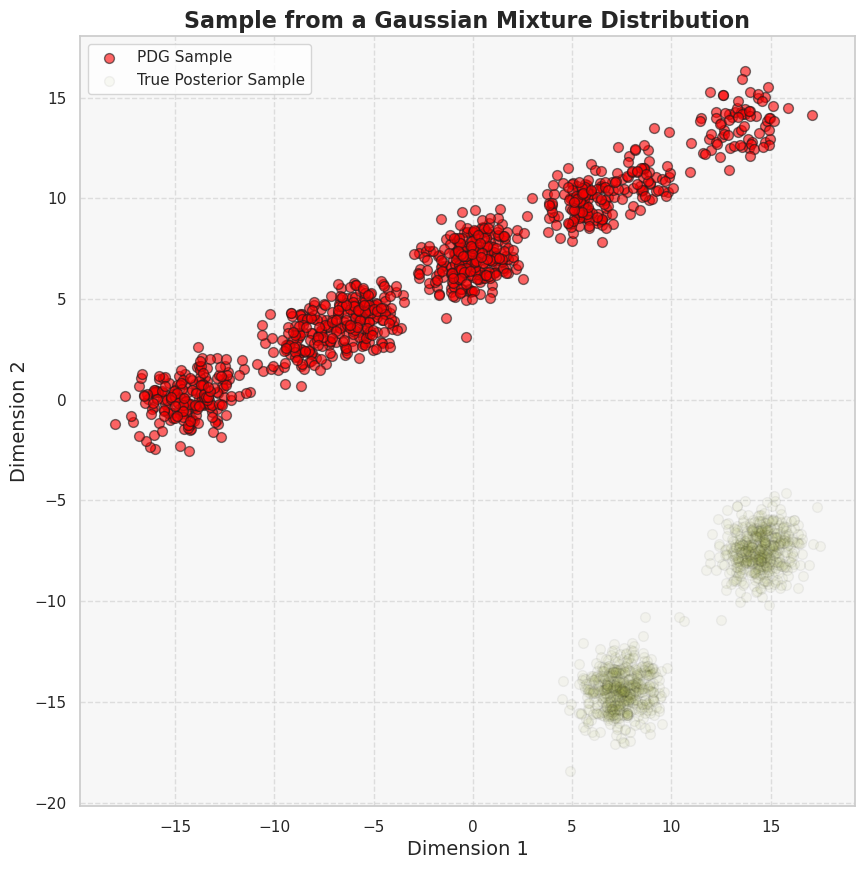

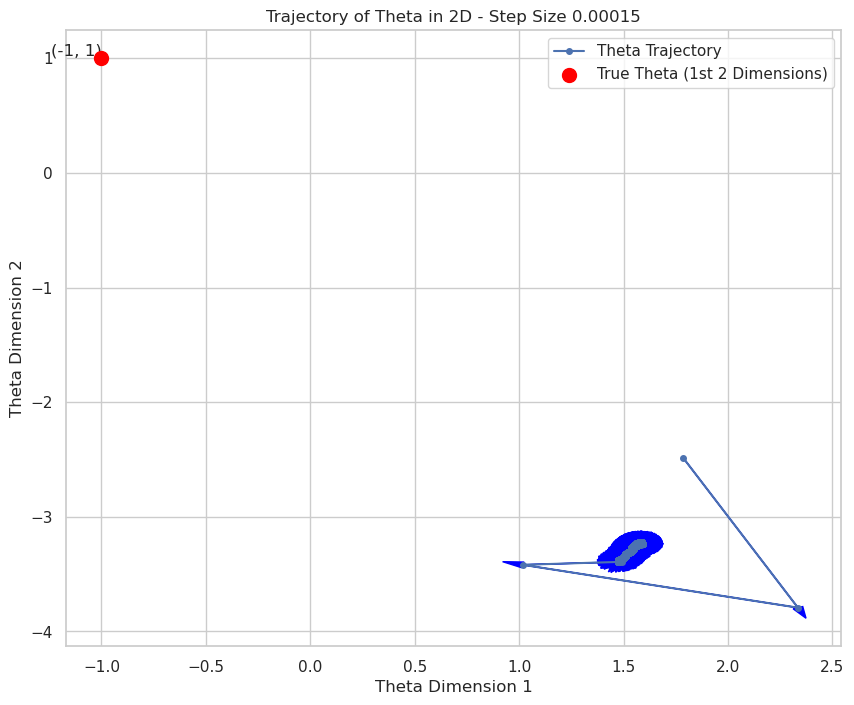

At the end, the number of NaN in the final sample of particle is 0


In [388]:
final_sample, theta_estimated, theta_traj = PGD_dx(1000, 8000, 0.00015, params_prior[0], params_prior[1], params_prior[2], theta_star, sigma_y, y_obs_dx, plot = True, plot_true_theta = theta_star)


100%|██████████| 8000/8000 [01:25<00:00, 93.65it/s] 


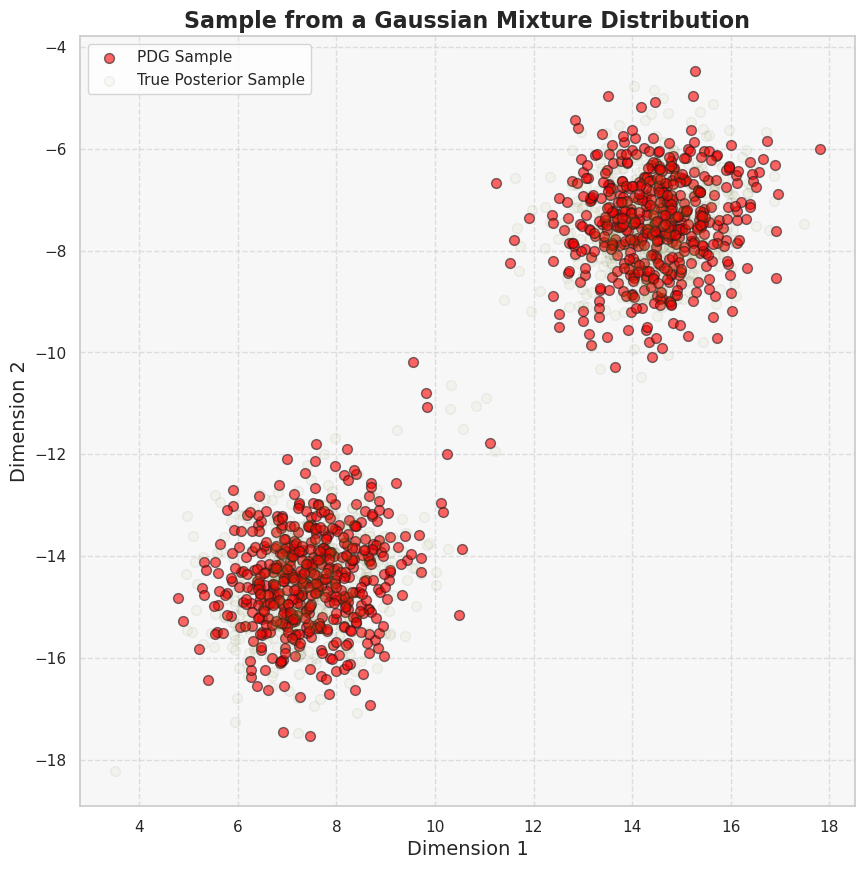

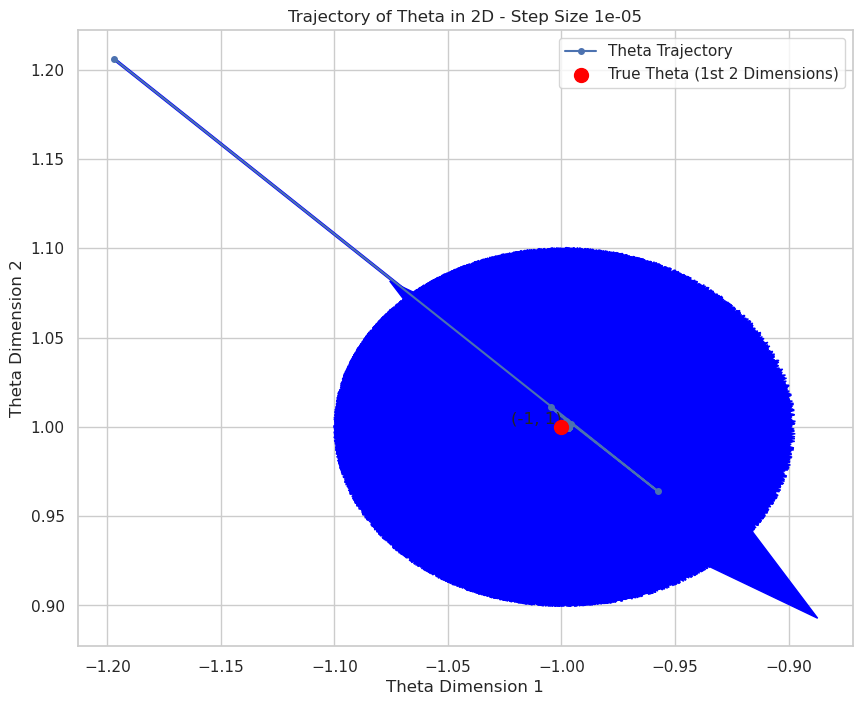

At the end, the number of NaN in the final sample of particle is 0
[-1.00011567  1.00003095 -1.00002255  0.99943053 -0.9994275   0.99933352
 -0.99981852  1.00012435 -1.00105781  1.0011217 ]


In [386]:
## Initialization of theta at origin
theta_0 = np.zeros(10)
sigma_y = 0.1

centers_posteriori, covariances_posteriori, weights_posteriori = post_params_dx(theta_star, 0.1, params_prior[0], params_prior[1], params_prior[2], y_obs_dx)
final_sample, theta_estimated, theta_traj = PGD_dx(1000, 8000, 0.00001, centers_posteriori, covariances_posteriori, weights_posteriori, theta_0, sigma_y, y_obs_dx, plot = True, plot_true_theta = theta_star)

print(theta_estimated)

We initialize $\theta_0$ = $(0,0, ...,0,0)$. 

  0%|          | 0/8000 [00:00<?, ?it/s]

100%|██████████| 8000/8000 [01:17<00:00, 102.89it/s]


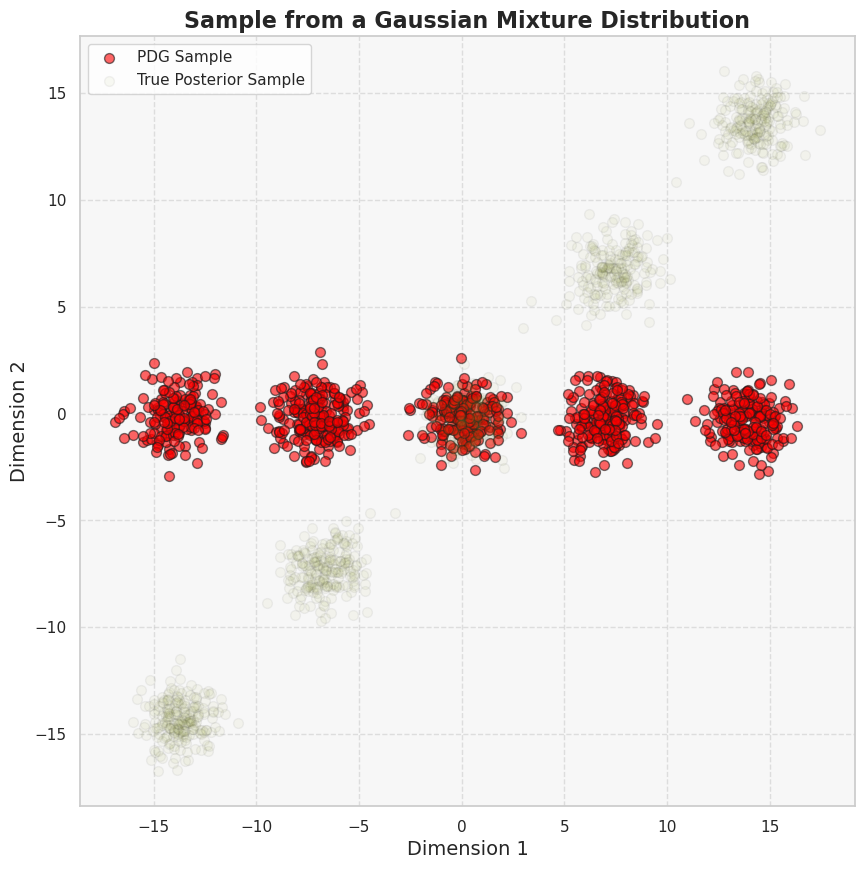

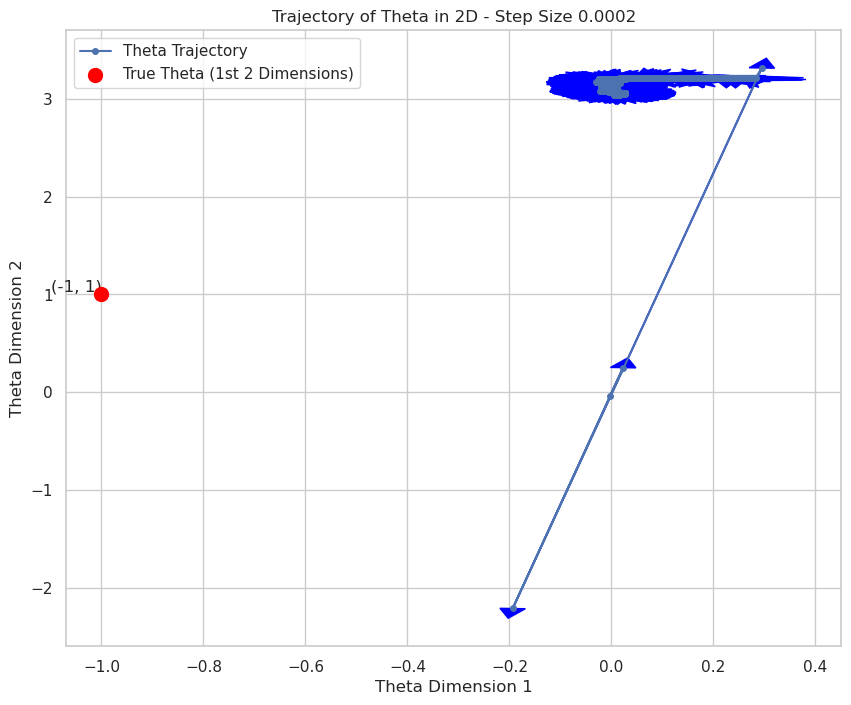

At the end, the number of NaN in the final sample of particle is 0
[ 4.95050459e-03  3.04057122e+00 -7.65208427e-04  3.02997373e+00
  1.59293021e-02  3.03301705e+00  2.34387121e-02  3.04637755e+00
  2.15972607e-02  3.07363094e+00]


In [480]:
## Initialization of theta at origin
theta_0 = np.zeros(10)
sigma_y = 0.1

final_sample, theta_estimated, theta_traj = PGD_dx(1000, 8000, 0.0002, params_prior[0], params_prior[1], params_prior[2], theta_0, sigma_y, y_obs_dx, plot = True, plot_true_theta = theta_star)

print(theta_estimated)

We can see that the particles at the end of PGD are distributed according the posterior distribution given $\theta_{estimated}$, which means that it is not the sampling the problem but the estimation of $\theta$. 

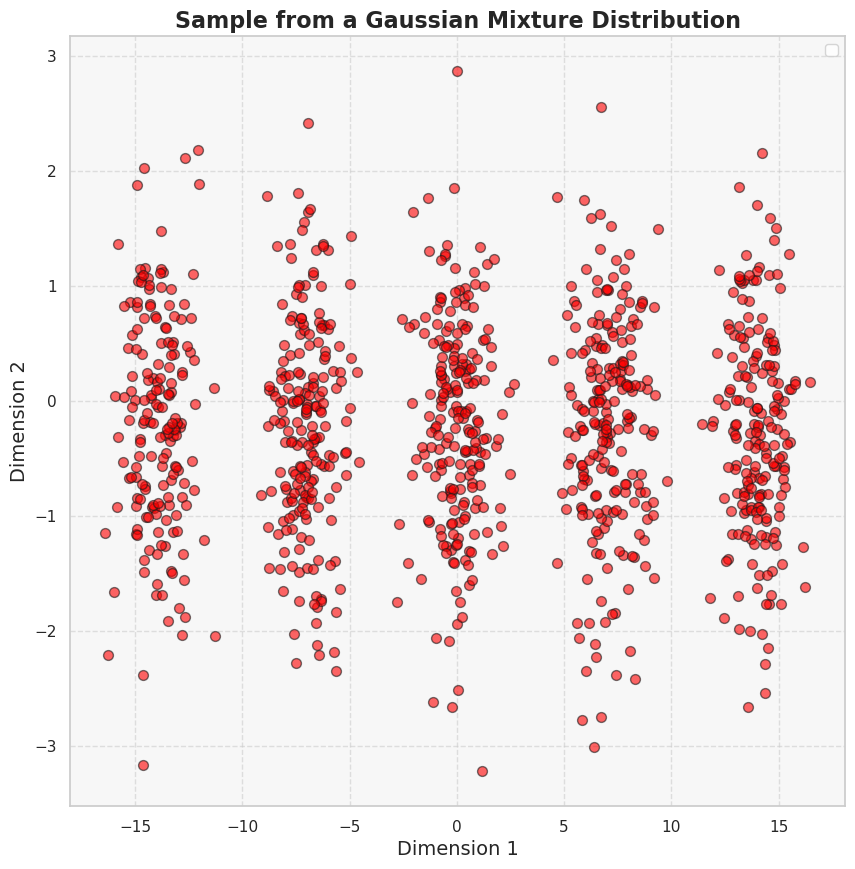

In [481]:
centers_posteriori, covariances_posteriori, weights_posteriori = post_params_dx(theta_estimated, 0.1, params_prior[0], params_prior[1], params_prior[2], y_obs_dx)

sample_post = sample_prior_dx(1000, centers_posteriori, covariances_posteriori, weights_posteriori)

plot_sample_dx(sample_post)

### Interacting Particle Langevin Algorithm 

**Inputs**: 
- Step size $ h $
- Number of steps $ K $
- Number of particles $ N $
- Initial particles $ X_0^1, \dots, X_0^N $
- Initial parameter estimates $ \theta_0 $

**Algorithm**:

1. For $ k = 0, \dots, K-1 $ do:
   
   a. **Update the parameter estimates**:
   
      $
      \theta_{k+1} = \theta_k + \frac{h}{N} \sum_{n=1}^{N} \nabla_{\theta} \ell(\theta_k, X_k^n) + \sqrt{\frac{2h}{N}} W_k^0
      $
   
   b. **Update the particles**: for all $ n = 1, \dots, N $,

      $
      X_{k+1}^n = X_k^n + h \nabla_{x} \ell(\theta_k, X_k^n) + \sqrt{2h} W_k^n
      $
      
      where $ W_k^1, \dots, W_k^N $ are i.i.d. random variables drawn from $ N(0, \mathbf{I}_{D_x}) $.

5. Return $ (\theta_k, q_k := \frac{1}{N} \sum_{n=1}^{N} \delta_{X_k^n})_{k=0}^{K} $


In [344]:

def IPLA_dx(nb_particles, nb_iter, step_size, centers_prior, covariances_prior, weights_prior, theta_0, sigma_y, y_obs, plot = False, plot_true_theta = None) : 
    """
    This function executes the Particle Gradient Descent in the context of our experiment. Given :
    - The number of particles
    - The number of iterations
    - The step size
    - Parameters of the prior distribution
    - The observed data point "y"
    - The initializing theta_0
    """

    theta_t = theta_0

    dx = theta_0.shape[0]

    sample = sample_prior_dx(nb_particles, centers_prior, covariances_prior, weights_prior)

    time_SDE = 0

    theta_traj = np.zeros((nb_iter, dx))

    for i in tqdm(range(nb_iter)) : 

        #We don't need to compute the parameters of the posteriori distribution given the updated theta because we use another formula
        #centers_post, covariances_post, weights_post = post_params(theta_t, sigma_y, centers_prior, covariances_prior, weights_prior)

        time_SDE += step_size

        ## on prend le gradient selon x de la posterior actualisée avec theta_t et qui est aussi une mixture Gaussienne
        grad = ((1/sigma_y**2) * theta_t[:, np.newaxis] * (y_obs - np.dot(theta_t, sample.T))).T 

        grad += grad_multimodal_opti(sample, weights_prior, centers_prior, covariances_prior) 

        grad_update = step_size * grad
        
        #Noise
        noise =  np.sqrt(2 * step_size) * np.random.randn(nb_particles, dx)

        sample += grad_update + noise #Warning sign

        #MAJ THETA we need a fct that compute gradient of the potential wrt to theta

        grad_theta = grad_theta_GM(sample, theta_t, y_obs, sigma_y) #renvoie un vecteur avec tous les gradients

        grad_theta_update = np.sum(grad_theta, axis = 0) ## ON MULTIPLIE CHAQUE PARTICLE A SON PAS SPECIFIQUE

        theta_noise = np.sqrt(2 * step_size / nb_particles) * np.random.randn(dx)

        theta_t = theta_t - (step_size / nb_particles) * grad_theta_update + theta_noise

        theta_traj[i] = theta_t

        if np.sum(np.isnan(sample)) // dx > 850:

            print('Too many NaN in the sample')
            
            return sample, theta_t, theta_traj

    if plot : 

        centers_post, covariances_post, weights_post = post_params_dx(plot_true_theta, sigma_y, centers_prior, covariances_prior, weights_prior, y_obs)
        
        sample_post = sample_prior_dx(1000, centers_post, covariances_post, weights_post)
        
        plot_sample_dx(sample, "IPLA Sample", sample_post, "True Posterior Sample")

        #plot
        plt.figure(figsize=(10, 8))

        plt.plot(theta_traj[:, 0], theta_traj[:, 1], 'o-', markersize=4, label='Theta Trajectory')

        for i in range(1, len(theta_traj)):

            plt.arrow(theta_traj[i-1, 0], theta_traj[i-1, 1], 
                    theta_traj[i, 0] - theta_traj[i-1, 0], 
                    theta_traj[i, 1] - theta_traj[i-1, 1], 
                    head_width=0.05, head_length=0.1, fc='blue', ec='blue')
            
        plt.scatter(plot_true_theta[0], plot_true_theta[1], color='red', s=100, zorder=5, label='True Theta (1st 2 Dimensions)')
        plt.text(plot_true_theta[0], plot_true_theta[1], s = f"({plot_true_theta[0]}, {plot_true_theta[1]})" , fontsize=12, verticalalignment='bottom', horizontalalignment='right')

        plt.xlabel('Theta Dimension 1')
        plt.ylabel('Theta Dimension 2')
        plt.title(f'Trajectory of Theta in 2D - Step Size {step_size}')
        plt.legend()
        plt.grid(True)
        plt.show() 

    print(f'At the end, the number of NaN in the final sample of particle is {np.sum(np.isnan(sample)) // dx}')

    return sample, theta_t, theta_traj

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 5/8000 [00:00<02:11, 60.61it/s]


Too many NaN in the sample


  0%|          | 5/8000 [00:00<01:54, 69.85it/s]


Too many NaN in the sample


  0%|          | 5/8000 [00:00<01:55, 69.41it/s]


Too many NaN in the sample


  0%|          | 5/8000 [00:00<01:42, 77.65it/s]


Too many NaN in the sample


  0%|          | 5/8000 [00:00<01:35, 83.95it/s]


Too many NaN in the sample


  0%|          | 5/8000 [00:00<01:58, 67.35it/s]


Too many NaN in the sample


  0%|          | 5/8000 [00:00<01:58, 67.54it/s]


Too many NaN in the sample


  0%|          | 5/8000 [00:00<01:32, 86.33it/s]


Too many NaN in the sample


  0%|          | 5/8000 [00:00<01:39, 80.32it/s]


Too many NaN in the sample


100%|██████████| 8000/8000 [01:31<00:00, 87.41it/s] 


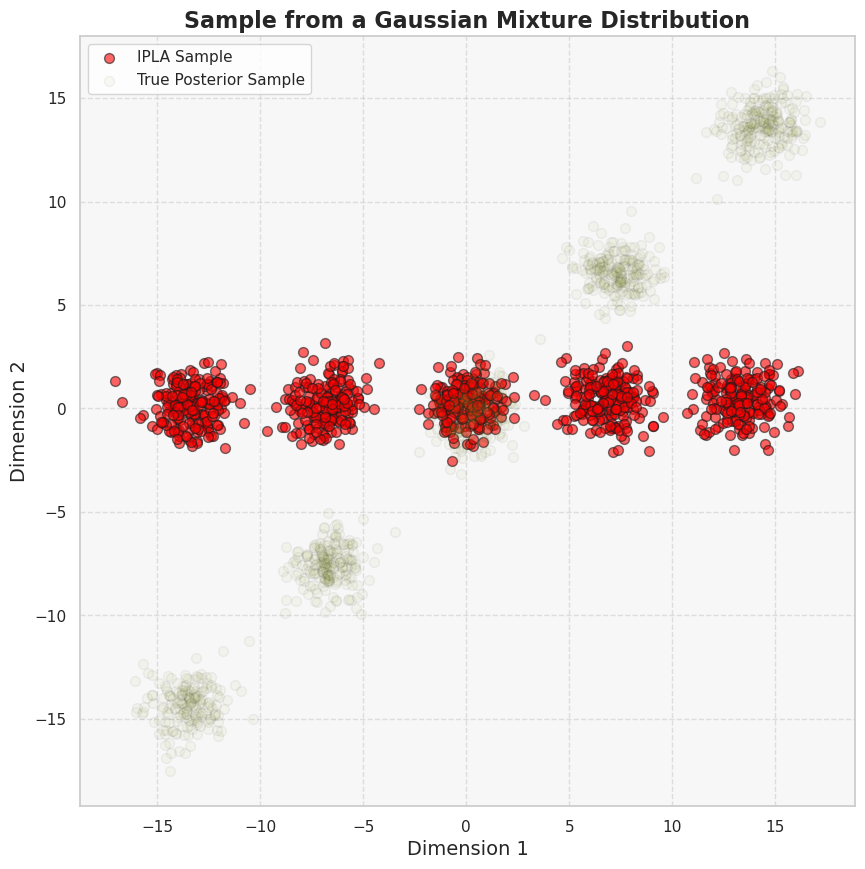

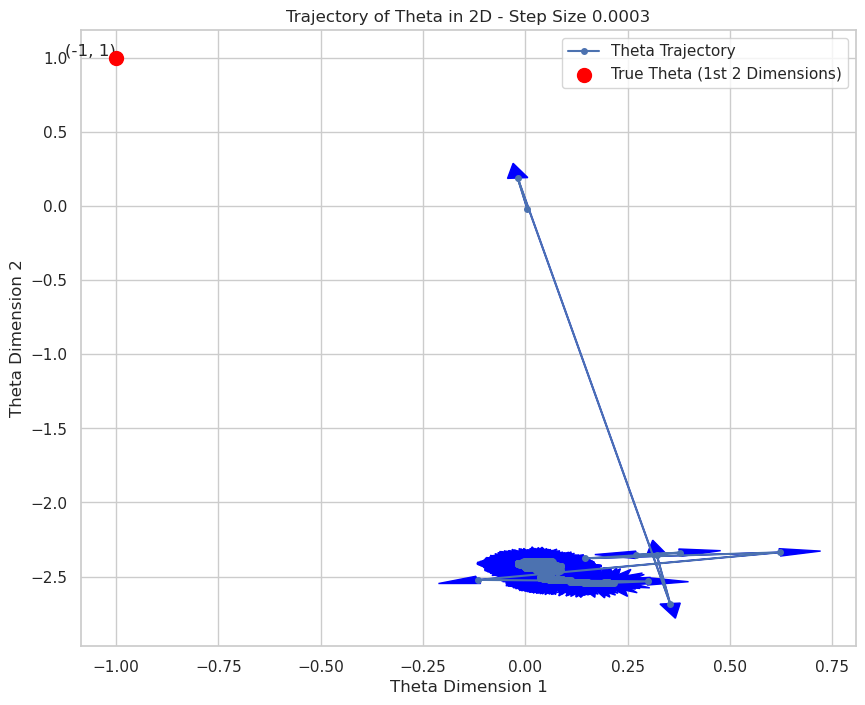

At the end, the number of NaN in the final sample of particle is 0
[ 0.04499834 -2.43724982 -0.06156404 -2.38904232 -0.05177564 -2.46002929
  0.09083481 -2.6244649   0.03394849 -2.49897857]


In [470]:
## Initialization of theta at origin
theta_0 = np.zeros(10)
sigma_y = 0.1

final_sample, theta_estimated, theta_traj = IPLA_dx(1000, 8000, 0.0003, params_prior[0], params_prior[1], params_prior[2], theta_0, sigma_y, y_obs_dx, plot = True, plot_true_theta = theta_star)

print(theta_estimated)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### IPLA with Dilation Path

(...)

In [9]:

def IPLA_Dilation_Adapt_dx(nb_particles, nb_iter, centers_prior, covariances_prior, weights_prior, theta_0, sigma_y, y_obs, start_schedule, end_schedule, 
                           alpha = 1, bound = 100, plot = False, plot_true_theta = None) : 
    """
    This function executes the Particle Gradient Descent in the context of our experiment. Given :
    - The number of particles
    - The number of iterations
    - The step size
    - Parameters of the prior distribution
    - The observed data point "y"
    - The initializing theta_0
    """

    theta_t = theta_0

    dx = theta_0.shape[0]

    sample = sample_prior_dx(nb_particles, centers_prior, covariances_prior, weights_prior)

    time_SDE = np.zeros(nb_particles)

    step_tab = np.full(nb_particles, start_schedule)

    theta_traj = np.zeros((nb_iter, dx))

    for i in tqdm(range(nb_iter)): 

        time_SDE += step_tab

        schedule = np.minimum(end_schedule, time_SDE) / end_schedule

        gamma = 1 / np.sqrt(schedule)

        gamma_sample = gamma[:, np.newaxis] * sample
        
        grad = ((1/sigma_y**2) * theta_t[:, np.newaxis] * (y_obs - np.dot(theta_t, gamma_sample.T))).T 

        grad += grad_multimodal_opti(gamma_sample, weights_prior, centers_prior, covariances_prior)

        grad = gamma[:, np.newaxis] * grad

        step_tab = np.minimum(1 / (np.linalg.norm(grad, axis = 1) + 1e-8), bound) * alpha #Vecteur de taille nb_particles qui donne le step pour chaque particle à cette itération

        noise = np.sqrt(2 * step_tab)[:, np.newaxis] * np.random.randn(nb_particles, dx)

        grad_update = step_tab[:, np.newaxis] * grad

        sample += grad_update + noise


        #MAJ THETA we need a fct that compute gradient of the potential wrt to theta

        grad_theta = grad_theta_GM(sample, theta_t, y_obs, sigma_y) #renvoie un vecteur avec tous les gradients

        grad_theta_update = np.sum(grad_theta, axis = 0) ## ON MULTIPLIE CHAQUE PARTICLE A SON PAS SPECIFIQUE

        theta_noise = np.sqrt(2 * alpha / nb_particles) * np.random.randn(dx)

        theta_t = theta_t - (alpha / nb_particles) * grad_theta_update + theta_noise

        theta_traj[i] = theta_t

        if np.sum(np.isnan(sample)) // dx > 850:

            print('Too many NaN in the sample')
            
            return sample, theta_t, theta_traj

    if plot : 

        centers_post, covariances_post, weights_post = post_params_dx(plot_true_theta, sigma_y, centers_prior, covariances_prior, weights_prior, y_obs)
        
        sample_post = sample_prior_dx(1000, centers_post, covariances_post, weights_post)
        
        plot_sample_dx(sample, "IPLA Sample", sample_post, "True Posterior Sample")

        #plot
        plt.figure(figsize=(10, 8))

        plt.plot(theta_traj[:, 0], theta_traj[:, 1], 'o-', markersize=4, label='Theta Trajectory')

        for i in range(1, len(theta_traj)):

            plt.arrow(theta_traj[i-1, 0], theta_traj[i-1, 1], 
                    theta_traj[i, 0] - theta_traj[i-1, 0], 
                    theta_traj[i, 1] - theta_traj[i-1, 1], 
                    head_width=0.05, head_length=0.1, fc='blue', ec='blue')
            
        plt.scatter(plot_true_theta[0], plot_true_theta[1], color='red', s=100, zorder=5, label='True Theta (1st 2 Dimensions)')
        plt.text(plot_true_theta[0], plot_true_theta[1], s = f"({plot_true_theta[0]}, {plot_true_theta[1]})" , fontsize=12, verticalalignment='bottom', horizontalalignment='right')

        plt.xlabel('Theta Dimension 1')
        plt.ylabel('Theta Dimension 2')
        plt.title(f'Trajectory of Theta in 2D - Step Size {step_size}')
        plt.legend()
        plt.grid(True)
        plt.show() 

    print(f'At the end, the number of NaN in the final sample of particle is {np.sum(np.isnan(sample)) // dx}')

    return sample, theta_t, theta_traj

100%|██████████| 800/800 [00:10<00:00, 77.39it/s] 


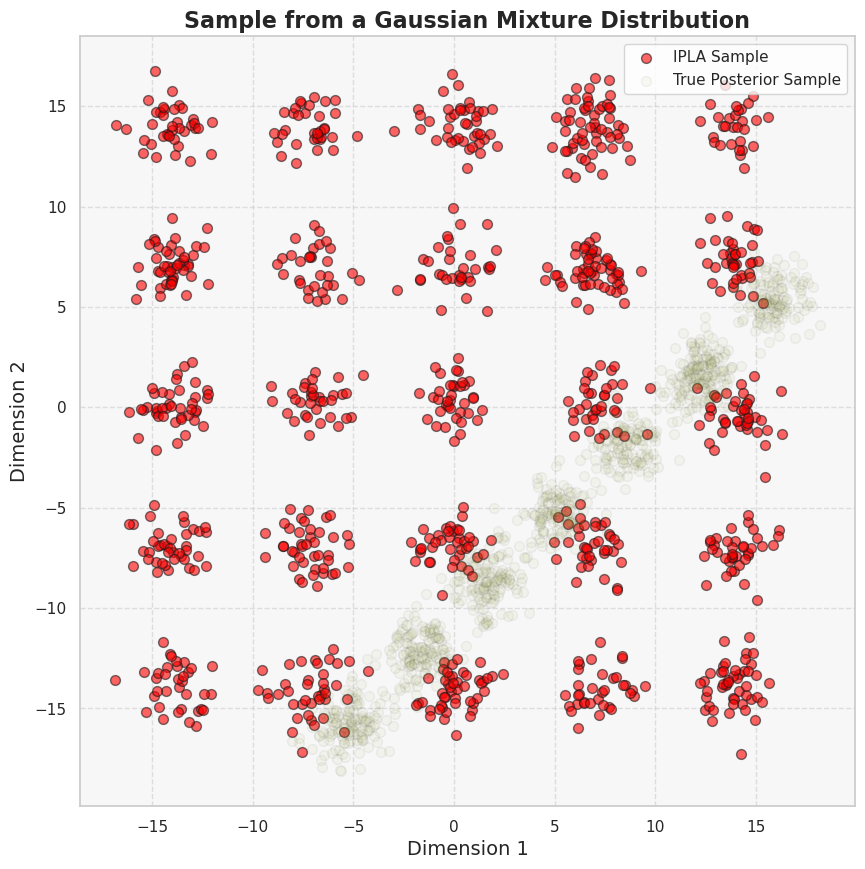

NameError: name 'step_size' is not defined

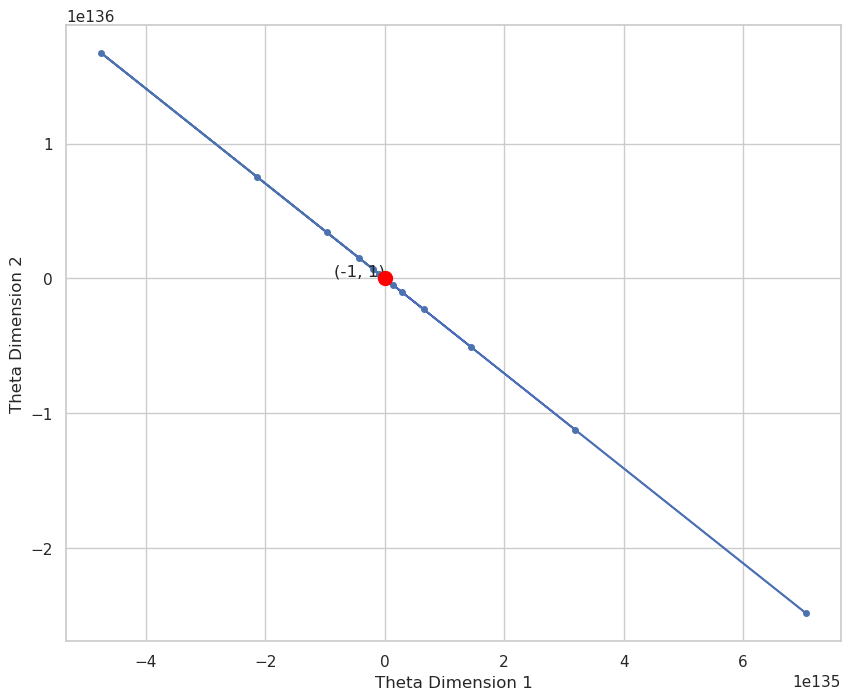

In [677]:
## Initialization of theta at origin
theta_0 = np.zeros(10)
sigma_y = 0.1

final_sample, theta_estimated, theta_traj = IPLA_Dilation_Adapt_dx(1000, 800, params_prior[0], params_prior[1], params_prior[2], theta_0, sigma_y, y_obs_dx, 1, 1, alpha = 0.00005, bound = 100, plot = True, plot_true_theta = theta_star)

print(theta_estimated)

Deuxieme exemple a posterior plus complexe : 

In [597]:
x_star = sample_prior_dx(1, params[0], params[1], params[2])

theta_star = np.tile([2, 0], 5)

y_obs_dx = generate_obs_dx(x_star, theta_star, 0.1)
y_obs_dx

array([197.20641672])

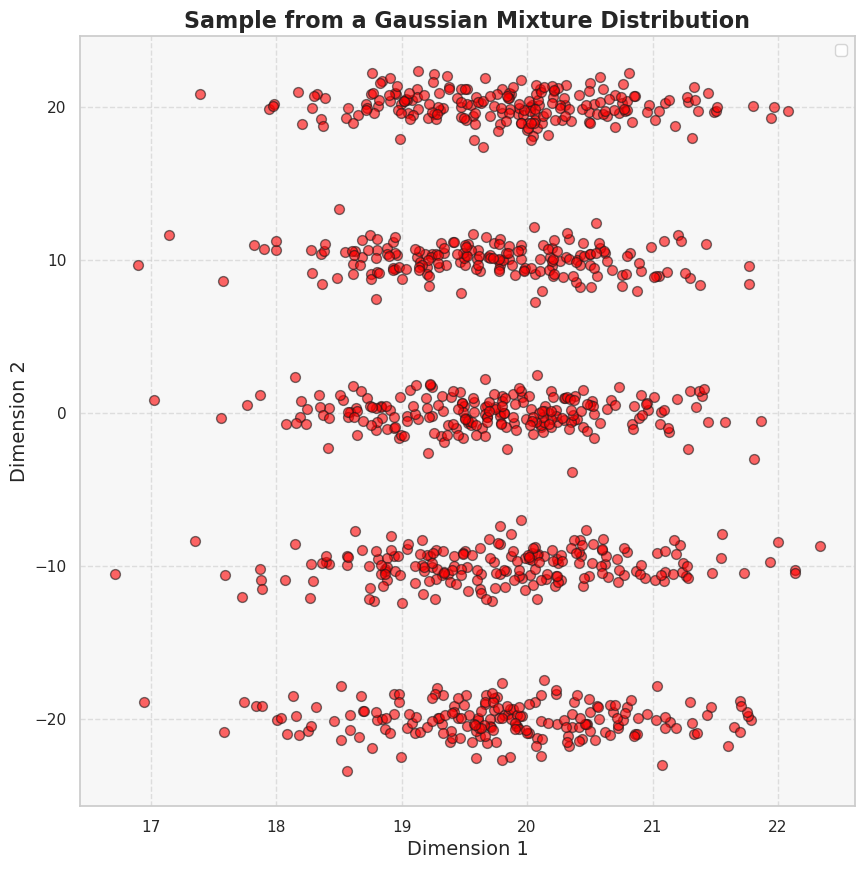

In [598]:
centers_posteriori, covariances_posteriori, weights_posteriori = post_params_dx(theta_star, 0.1, params[0], params[1], params[2], y_obs_dx)

sample_post = sample_prior_dx(1000, centers_posteriori, covariances_posteriori, weights_posteriori)

plot_sample_dx(sample_post)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:24<00:00, 82.40it/s]


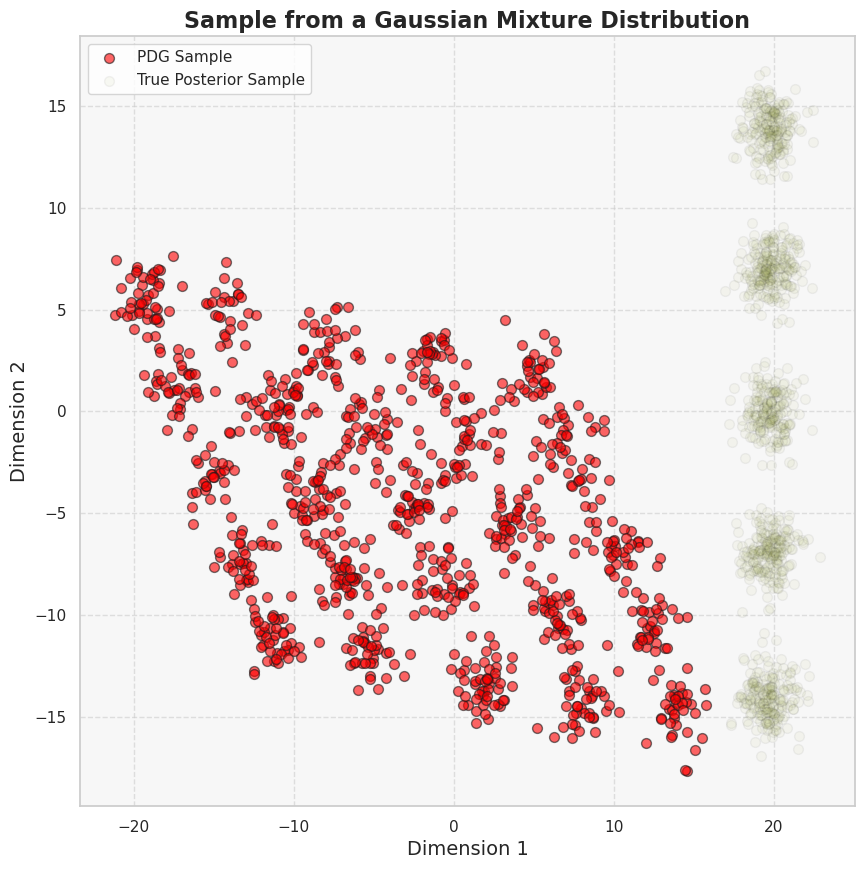

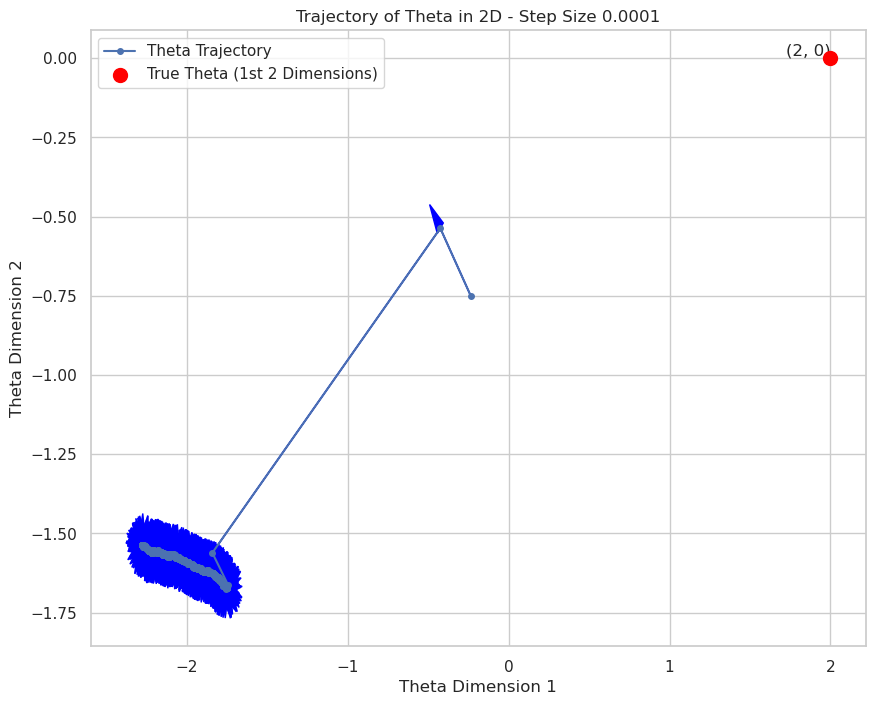

At the end, the number of NaN in the final sample of particle is 0


  0%|          | 6/2000 [00:00<00:24, 82.98it/s]


Too many NaN in the sample


  0%|          | 8/2000 [00:00<00:32, 60.39it/s]


Too many NaN in the sample


 49%|████▊     | 973/2000 [00:13<00:13, 74.23it/s] 


Too many NaN in the sample


  0%|          | 7/2000 [00:00<00:24, 81.14it/s]


Too many NaN in the sample


  0%|          | 7/2000 [00:00<00:24, 82.20it/s]


Too many NaN in the sample


  0%|          | 10/2000 [00:00<00:24, 81.57it/s]


Too many NaN in the sample


  0%|          | 7/2000 [00:00<00:24, 80.80it/s]


Too many NaN in the sample


  0%|          | 8/2000 [00:00<00:25, 78.25it/s]

Too many NaN in the sample
[nan nan nan nan nan nan nan nan nan nan]


In [645]:
## Initialization of theta at origin
theta_0 = np.zeros(10)
sigma_y = 0.1

final_sample, theta_estimated, theta_traj = PGD_dx(1000, 2000, 0.0001, params_prior[0], params_prior[1], params_prior[2], theta_0, sigma_y, y_obs_dx, plot = True, plot_true_theta = theta_star)

print(theta_estimated)

100%|██████████| 2000/2000 [00:26<00:00, 75.33it/s]


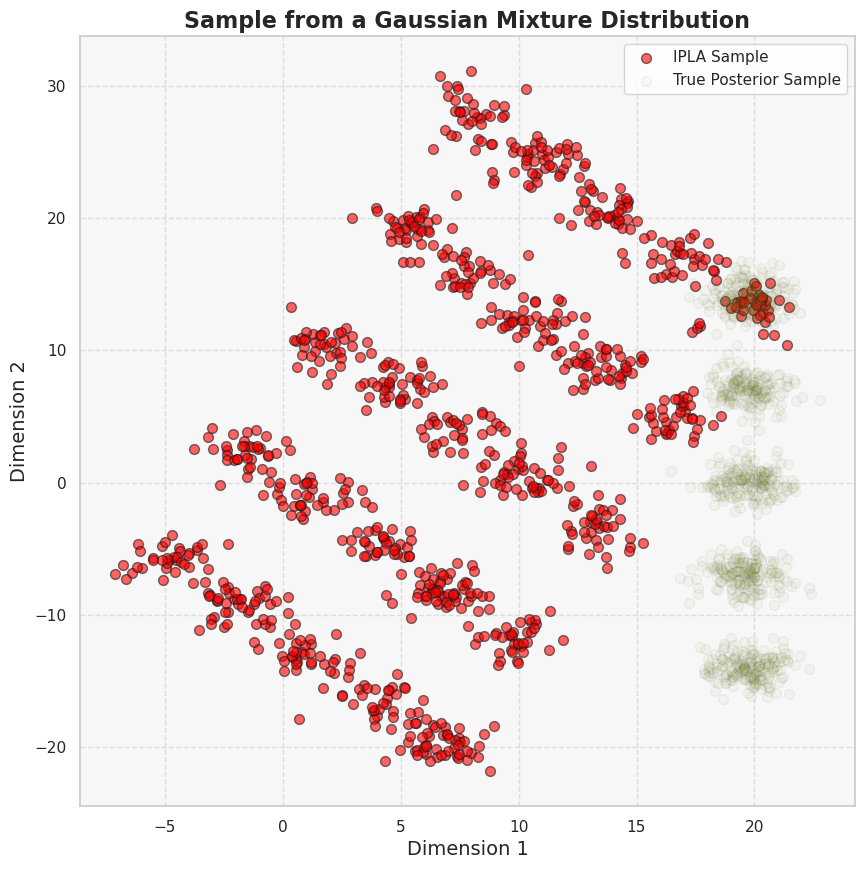

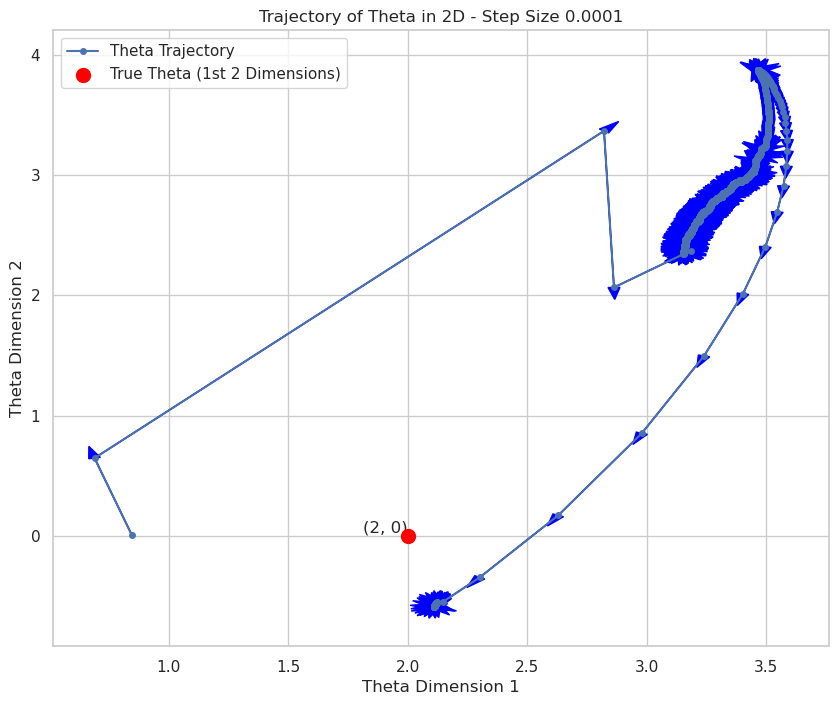

At the end, the number of NaN in the final sample of particle is 0


  0%|          | 8/2000 [00:00<00:23, 85.45it/s]


Too many NaN in the sample


  0%|          | 6/2000 [00:00<00:24, 81.14it/s]


Too many NaN in the sample


  0%|          | 7/2000 [00:00<00:17, 112.05it/s]


Too many NaN in the sample


  0%|          | 6/2000 [00:00<00:23, 85.37it/s]


Too many NaN in the sample


  0%|          | 7/2000 [00:00<00:25, 77.54it/s]


Too many NaN in the sample


  0%|          | 7/2000 [00:00<00:23, 83.82it/s]


Too many NaN in the sample


  1%|          | 22/2000 [00:00<00:21, 93.82it/s]


Too many NaN in the sample


  1%|          | 13/2000 [00:00<00:23, 86.10it/s]


Too many NaN in the sample


  1%|          | 11/2000 [00:00<00:22, 89.90it/s]


Too many NaN in the sample


  0%|          | 5/2000 [00:00<00:36, 55.04it/s]


Too many NaN in the sample


  0%|          | 7/2000 [00:00<00:30, 66.03it/s]

Too many NaN in the sample
[nan nan nan nan nan nan nan nan nan nan]


In [641]:
## Initialization of theta at origin
theta_0 = np.zeros(10)
sigma_y = 0.1

final_sample, theta_estimated, theta_traj = IPLA_dx(1000, 2000, 0.0001, params_prior[0], params_prior[1], params_prior[2], theta_0, sigma_y, y_obs_dx, plot = True, plot_true_theta = theta_star)

print(theta_estimated)

### Repartition of estimations of $\theta^{*}$

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

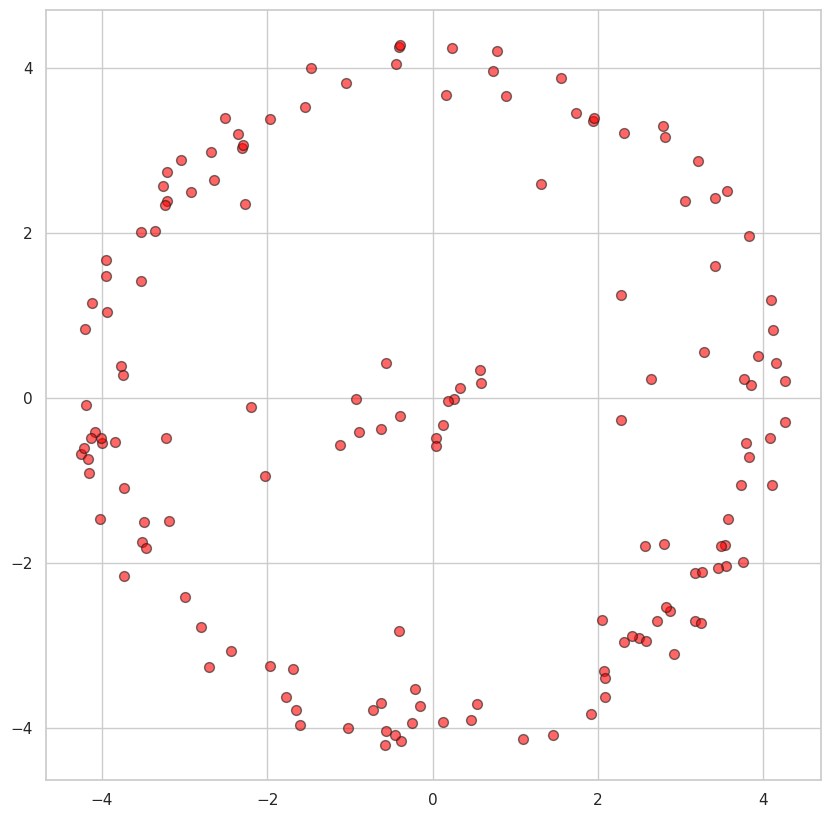

In [499]:
plot_sample_dx(theta_estimated_list, 'Repartition Thetas', theta_star, 'True Theta')

In [497]:
## Initialization of theta at origin
theta_0 = np.zeros(10)
sigma_y = 0.1
theta_estimated_list = np.zeros((150, 10))

for i in tqdm(range(150)):

    final_sample, theta_estimated, theta_traj = PGD_dx(1000, 1000, 0.00011, params_prior[0], params_prior[1], params_prior[2], theta_0, sigma_y, y_obs_dx, plot = False)
    theta_estimated_list[i] = theta_estimated

  1%|          | 1/150 [00:11<28:14, 11.37s/it]

At the end, the number of NaN in the final sample of particle is 0


  1%|▏         | 2/150 [00:22<27:59, 11.35s/it]

At the end, the number of NaN in the final sample of particle is 0


  2%|▏         | 3/150 [00:32<26:33, 10.84s/it]

At the end, the number of NaN in the final sample of particle is 0


  3%|▎         | 4/150 [00:44<26:40, 10.96s/it]

At the end, the number of NaN in the final sample of particle is 0


  3%|▎         | 5/150 [00:55<27:09, 11.24s/it]

At the end, the number of NaN in the final sample of particle is 0


  4%|▍         | 6/150 [01:07<27:11, 11.33s/it]

At the end, the number of NaN in the final sample of particle is 0


  5%|▍         | 7/150 [01:18<27:13, 11.42s/it]

At the end, the number of NaN in the final sample of particle is 0


  5%|▌         | 8/150 [01:29<26:37, 11.25s/it]

At the end, the number of NaN in the final sample of particle is 0


  6%|▌         | 9/150 [01:41<26:24, 11.24s/it]

At the end, the number of NaN in the final sample of particle is 0


  7%|▋         | 10/150 [01:51<25:24, 10.89s/it]

At the end, the number of NaN in the final sample of particle is 0


  7%|▋         | 11/150 [02:03<25:57, 11.20s/it]

At the end, the number of NaN in the final sample of particle is 0


  8%|▊         | 12/150 [02:14<26:03, 11.33s/it]

At the end, the number of NaN in the final sample of particle is 0


  9%|▊         | 13/150 [02:26<26:04, 11.42s/it]

At the end, the number of NaN in the final sample of particle is 0


  9%|▉         | 14/150 [02:37<25:29, 11.25s/it]

At the end, the number of NaN in the final sample of particle is 0


 10%|█         | 15/150 [02:48<25:33, 11.36s/it]

At the end, the number of NaN in the final sample of particle is 0


 11%|█         | 16/150 [02:58<24:35, 11.01s/it]

At the end, the number of NaN in the final sample of particle is 0


 11%|█▏        | 17/150 [03:10<24:31, 11.06s/it]

At the end, the number of NaN in the final sample of particle is 0


 12%|█▏        | 18/150 [03:21<24:15, 11.03s/it]

At the end, the number of NaN in the final sample of particle is 0


 13%|█▎        | 19/150 [03:31<23:44, 10.87s/it]

At the end, the number of NaN in the final sample of particle is 0


 13%|█▎        | 20/150 [03:42<23:32, 10.86s/it]

At the end, the number of NaN in the final sample of particle is 0


 14%|█▍        | 21/150 [03:54<23:57, 11.14s/it]

At the end, the number of NaN in the final sample of particle is 0


 15%|█▍        | 22/150 [04:06<24:22, 11.42s/it]

At the end, the number of NaN in the final sample of particle is 0


 15%|█▌        | 23/150 [04:17<24:16, 11.47s/it]

At the end, the number of NaN in the final sample of particle is 0


 16%|█▌        | 24/150 [04:28<23:29, 11.18s/it]

At the end, the number of NaN in the final sample of particle is 0


 17%|█▋        | 25/150 [04:39<23:09, 11.11s/it]

At the end, the number of NaN in the final sample of particle is 0


 17%|█▋        | 26/150 [04:50<22:42, 10.99s/it]

At the end, the number of NaN in the final sample of particle is 0


 18%|█▊        | 27/150 [05:00<22:29, 10.97s/it]

At the end, the number of NaN in the final sample of particle is 0


 19%|█▊        | 28/150 [05:12<22:28, 11.05s/it]

At the end, the number of NaN in the final sample of particle is 0


 19%|█▉        | 29/150 [05:23<22:15, 11.04s/it]

At the end, the number of NaN in the final sample of particle is 0


 20%|██        | 30/150 [05:34<22:14, 11.12s/it]

At the end, the number of NaN in the final sample of particle is 0


 21%|██        | 31/150 [05:44<21:34, 10.88s/it]

At the end, the number of NaN in the final sample of particle is 0


 21%|██▏       | 32/150 [05:55<21:31, 10.94s/it]

At the end, the number of NaN in the final sample of particle is 0


 22%|██▏       | 33/150 [06:06<20:56, 10.74s/it]

At the end, the number of NaN in the final sample of particle is 0


 23%|██▎       | 34/150 [06:17<20:51, 10.79s/it]

At the end, the number of NaN in the final sample of particle is 0


 23%|██▎       | 35/150 [06:28<20:50, 10.87s/it]

At the end, the number of NaN in the final sample of particle is 0


 24%|██▍       | 36/150 [06:38<20:33, 10.82s/it]

At the end, the number of NaN in the final sample of particle is 0


 25%|██▍       | 37/150 [06:49<20:07, 10.68s/it]

At the end, the number of NaN in the final sample of particle is 0


 25%|██▌       | 38/150 [07:00<20:19, 10.89s/it]

At the end, the number of NaN in the final sample of particle is 0


 26%|██▌       | 39/150 [07:12<20:37, 11.15s/it]

At the end, the number of NaN in the final sample of particle is 0


 27%|██▋       | 40/150 [07:23<20:19, 11.09s/it]

At the end, the number of NaN in the final sample of particle is 0


 27%|██▋       | 41/150 [07:34<20:22, 11.21s/it]

At the end, the number of NaN in the final sample of particle is 0


 28%|██▊       | 42/150 [07:46<20:31, 11.40s/it]

At the end, the number of NaN in the final sample of particle is 0


 29%|██▊       | 43/150 [07:58<20:18, 11.38s/it]

At the end, the number of NaN in the final sample of particle is 0


 29%|██▉       | 44/150 [08:09<20:04, 11.36s/it]

At the end, the number of NaN in the final sample of particle is 0


 30%|███       | 45/150 [08:20<19:32, 11.17s/it]

At the end, the number of NaN in the final sample of particle is 0


 31%|███       | 46/150 [08:31<19:28, 11.24s/it]

At the end, the number of NaN in the final sample of particle is 0


 31%|███▏      | 47/150 [08:43<19:28, 11.35s/it]

At the end, the number of NaN in the final sample of particle is 0


 32%|███▏      | 48/150 [08:54<19:30, 11.47s/it]

At the end, the number of NaN in the final sample of particle is 0


 33%|███▎      | 49/150 [09:05<18:43, 11.12s/it]

At the end, the number of NaN in the final sample of particle is 0


 33%|███▎      | 50/150 [09:16<18:30, 11.10s/it]

At the end, the number of NaN in the final sample of particle is 0


 34%|███▍      | 51/150 [09:26<18:06, 10.97s/it]

At the end, the number of NaN in the final sample of particle is 0


 35%|███▍      | 52/150 [09:37<18:00, 11.02s/it]

At the end, the number of NaN in the final sample of particle is 0


 35%|███▌      | 53/150 [09:49<18:17, 11.31s/it]

At the end, the number of NaN in the final sample of particle is 0


 36%|███▌      | 54/150 [10:00<17:47, 11.12s/it]

At the end, the number of NaN in the final sample of particle is 0


 37%|███▋      | 55/150 [10:11<17:34, 11.10s/it]

At the end, the number of NaN in the final sample of particle is 0


 37%|███▋      | 56/150 [10:22<17:28, 11.16s/it]

At the end, the number of NaN in the final sample of particle is 0


 38%|███▊      | 57/150 [10:34<17:28, 11.28s/it]

At the end, the number of NaN in the final sample of particle is 0


 39%|███▊      | 58/150 [10:44<16:54, 11.03s/it]

At the end, the number of NaN in the final sample of particle is 0


 39%|███▉      | 59/150 [10:55<16:36, 10.96s/it]

At the end, the number of NaN in the final sample of particle is 0


 40%|████      | 60/150 [11:06<16:20, 10.89s/it]

At the end, the number of NaN in the final sample of particle is 0


 41%|████      | 61/150 [11:17<16:03, 10.82s/it]

At the end, the number of NaN in the final sample of particle is 0


 41%|████▏     | 62/150 [11:28<15:55, 10.85s/it]

At the end, the number of NaN in the final sample of particle is 0


 42%|████▏     | 63/150 [11:38<15:37, 10.77s/it]

At the end, the number of NaN in the final sample of particle is 0


 43%|████▎     | 64/150 [11:50<15:44, 10.98s/it]

At the end, the number of NaN in the final sample of particle is 0


 43%|████▎     | 65/150 [12:00<15:25, 10.89s/it]

At the end, the number of NaN in the final sample of particle is 0


 44%|████▍     | 66/150 [12:11<15:07, 10.81s/it]

At the end, the number of NaN in the final sample of particle is 0


 45%|████▍     | 67/150 [12:22<15:07, 10.93s/it]

At the end, the number of NaN in the final sample of particle is 0


 45%|████▌     | 68/150 [12:33<14:46, 10.81s/it]

At the end, the number of NaN in the final sample of particle is 0


 46%|████▌     | 69/150 [12:43<14:26, 10.69s/it]

At the end, the number of NaN in the final sample of particle is 0


 47%|████▋     | 70/150 [12:54<14:15, 10.69s/it]

At the end, the number of NaN in the final sample of particle is 0


 47%|████▋     | 71/150 [13:05<14:18, 10.87s/it]

At the end, the number of NaN in the final sample of particle is 0


 48%|████▊     | 72/150 [13:15<13:45, 10.58s/it]

At the end, the number of NaN in the final sample of particle is 0


 49%|████▊     | 73/150 [13:25<13:18, 10.38s/it]

At the end, the number of NaN in the final sample of particle is 0


 49%|████▉     | 74/150 [13:36<13:21, 10.55s/it]

At the end, the number of NaN in the final sample of particle is 0


 50%|█████     | 75/150 [13:47<13:29, 10.80s/it]

At the end, the number of NaN in the final sample of particle is 0


 51%|█████     | 76/150 [13:58<13:12, 10.71s/it]

At the end, the number of NaN in the final sample of particle is 0


 51%|█████▏    | 77/150 [14:08<13:02, 10.72s/it]

At the end, the number of NaN in the final sample of particle is 0


 52%|█████▏    | 78/150 [14:19<12:49, 10.69s/it]

At the end, the number of NaN in the final sample of particle is 0


 53%|█████▎    | 79/150 [14:30<12:39, 10.69s/it]

At the end, the number of NaN in the final sample of particle is 0


 53%|█████▎    | 80/150 [14:41<12:49, 11.00s/it]

At the end, the number of NaN in the final sample of particle is 0


 54%|█████▍    | 81/150 [14:53<12:48, 11.14s/it]

At the end, the number of NaN in the final sample of particle is 0


 55%|█████▍    | 82/150 [15:04<12:43, 11.23s/it]

At the end, the number of NaN in the final sample of particle is 0


 55%|█████▌    | 83/150 [15:16<12:44, 11.41s/it]

At the end, the number of NaN in the final sample of particle is 0


 56%|█████▌    | 84/150 [15:27<12:10, 11.07s/it]

At the end, the number of NaN in the final sample of particle is 0


 57%|█████▋    | 85/150 [15:38<12:07, 11.19s/it]

At the end, the number of NaN in the final sample of particle is 0


 57%|█████▋    | 86/150 [15:50<12:03, 11.31s/it]

At the end, the number of NaN in the final sample of particle is 0


 58%|█████▊    | 87/150 [16:01<12:00, 11.43s/it]

At the end, the number of NaN in the final sample of particle is 0


 59%|█████▊    | 88/150 [16:12<11:36, 11.24s/it]

At the end, the number of NaN in the final sample of particle is 0


 59%|█████▉    | 89/150 [16:24<11:37, 11.43s/it]

At the end, the number of NaN in the final sample of particle is 0


 60%|██████    | 90/150 [16:36<11:30, 11.51s/it]

At the end, the number of NaN in the final sample of particle is 0


 61%|██████    | 91/150 [16:47<11:07, 11.31s/it]

At the end, the number of NaN in the final sample of particle is 0


 61%|██████▏   | 92/150 [17:00<11:26, 11.83s/it]

At the end, the number of NaN in the final sample of particle is 0


 62%|██████▏   | 93/150 [17:18<13:04, 13.76s/it]

At the end, the number of NaN in the final sample of particle is 0


 63%|██████▎   | 94/150 [17:36<13:58, 14.98s/it]

At the end, the number of NaN in the final sample of particle is 0


 63%|██████▎   | 95/150 [17:54<14:35, 15.92s/it]

At the end, the number of NaN in the final sample of particle is 0


 64%|██████▍   | 96/150 [18:11<14:46, 16.41s/it]

At the end, the number of NaN in the final sample of particle is 0


 65%|██████▍   | 97/150 [18:24<13:27, 15.23s/it]

At the end, the number of NaN in the final sample of particle is 0


 65%|██████▌   | 98/150 [18:35<12:06, 13.97s/it]

At the end, the number of NaN in the final sample of particle is 0


 66%|██████▌   | 99/150 [18:46<11:09, 13.13s/it]

At the end, the number of NaN in the final sample of particle is 0


 67%|██████▋   | 100/150 [18:57<10:27, 12.55s/it]

At the end, the number of NaN in the final sample of particle is 0


 67%|██████▋   | 101/150 [19:07<09:41, 11.86s/it]

At the end, the number of NaN in the final sample of particle is 0


 68%|██████▊   | 102/150 [19:19<09:22, 11.72s/it]

At the end, the number of NaN in the final sample of particle is 0


 69%|██████▊   | 103/150 [19:30<08:57, 11.44s/it]

At the end, the number of NaN in the final sample of particle is 0


 69%|██████▉   | 104/150 [19:41<08:38, 11.28s/it]

At the end, the number of NaN in the final sample of particle is 0


 70%|███████   | 105/150 [19:58<09:47, 13.05s/it]

At the end, the number of NaN in the final sample of particle is 0


 71%|███████   | 106/150 [20:17<10:52, 14.83s/it]

At the end, the number of NaN in the final sample of particle is 0


 71%|███████▏  | 107/150 [20:32<10:41, 14.91s/it]

At the end, the number of NaN in the final sample of particle is 0


 72%|███████▏  | 108/150 [20:44<09:54, 14.17s/it]

At the end, the number of NaN in the final sample of particle is 0


 73%|███████▎  | 109/150 [20:55<08:53, 13.01s/it]

At the end, the number of NaN in the final sample of particle is 0


 73%|███████▎  | 110/150 [21:06<08:17, 12.45s/it]

At the end, the number of NaN in the final sample of particle is 0


 74%|███████▍  | 111/150 [21:16<07:45, 11.95s/it]

At the end, the number of NaN in the final sample of particle is 0


 75%|███████▍  | 112/150 [21:29<07:40, 12.11s/it]

At the end, the number of NaN in the final sample of particle is 0


 75%|███████▌  | 113/150 [21:42<07:35, 12.30s/it]

At the end, the number of NaN in the final sample of particle is 0


 76%|███████▌  | 114/150 [21:53<07:10, 11.97s/it]

At the end, the number of NaN in the final sample of particle is 0


 77%|███████▋  | 115/150 [22:05<06:59, 11.99s/it]

At the end, the number of NaN in the final sample of particle is 0


 77%|███████▋  | 116/150 [22:17<06:47, 11.99s/it]

At the end, the number of NaN in the final sample of particle is 0


 78%|███████▊  | 117/150 [22:28<06:25, 11.67s/it]

At the end, the number of NaN in the final sample of particle is 0


 79%|███████▊  | 118/150 [22:39<06:07, 11.50s/it]

At the end, the number of NaN in the final sample of particle is 0


 79%|███████▉  | 119/150 [22:50<05:48, 11.25s/it]

At the end, the number of NaN in the final sample of particle is 0


 80%|████████  | 120/150 [23:01<05:35, 11.18s/it]

At the end, the number of NaN in the final sample of particle is 0


 81%|████████  | 121/150 [23:11<05:19, 11.02s/it]

At the end, the number of NaN in the final sample of particle is 0


 81%|████████▏ | 122/150 [23:21<04:57, 10.64s/it]

At the end, the number of NaN in the final sample of particle is 0


 82%|████████▏ | 123/150 [23:32<04:47, 10.64s/it]

At the end, the number of NaN in the final sample of particle is 0


 83%|████████▎ | 124/150 [23:41<04:29, 10.35s/it]

At the end, the number of NaN in the final sample of particle is 0


 83%|████████▎ | 125/150 [23:52<04:22, 10.48s/it]

At the end, the number of NaN in the final sample of particle is 0


 84%|████████▍ | 126/150 [24:03<04:11, 10.49s/it]

At the end, the number of NaN in the final sample of particle is 0


 85%|████████▍ | 127/150 [24:12<03:53, 10.16s/it]

At the end, the number of NaN in the final sample of particle is 0


 85%|████████▌ | 128/150 [24:21<03:38,  9.94s/it]

At the end, the number of NaN in the final sample of particle is 0


 86%|████████▌ | 129/150 [24:31<03:26,  9.82s/it]

At the end, the number of NaN in the final sample of particle is 0


 87%|████████▋ | 130/150 [24:42<03:22, 10.11s/it]

At the end, the number of NaN in the final sample of particle is 0


 87%|████████▋ | 131/150 [24:53<03:19, 10.48s/it]

At the end, the number of NaN in the final sample of particle is 0


 88%|████████▊ | 132/150 [25:04<03:13, 10.74s/it]

At the end, the number of NaN in the final sample of particle is 0


 89%|████████▊ | 133/150 [25:15<02:59, 10.56s/it]

At the end, the number of NaN in the final sample of particle is 0


 89%|████████▉ | 134/150 [25:26<02:54, 10.88s/it]

At the end, the number of NaN in the final sample of particle is 0


 90%|█████████ | 135/150 [25:37<02:44, 10.99s/it]

At the end, the number of NaN in the final sample of particle is 0


 91%|█████████ | 136/150 [25:49<02:34, 11.02s/it]

At the end, the number of NaN in the final sample of particle is 0


 91%|█████████▏| 137/150 [25:59<02:20, 10.82s/it]

At the end, the number of NaN in the final sample of particle is 0


 92%|█████████▏| 138/150 [26:10<02:09, 10.81s/it]

At the end, the number of NaN in the final sample of particle is 0


 93%|█████████▎| 139/150 [26:20<01:56, 10.59s/it]

At the end, the number of NaN in the final sample of particle is 0


 93%|█████████▎| 140/150 [26:30<01:45, 10.59s/it]

At the end, the number of NaN in the final sample of particle is 0


 94%|█████████▍| 141/150 [26:41<01:35, 10.63s/it]

At the end, the number of NaN in the final sample of particle is 0


 95%|█████████▍| 142/150 [26:51<01:23, 10.48s/it]

At the end, the number of NaN in the final sample of particle is 0


 95%|█████████▌| 143/150 [27:01<01:12, 10.38s/it]

At the end, the number of NaN in the final sample of particle is 0


 96%|█████████▌| 144/150 [27:12<01:01, 10.33s/it]

At the end, the number of NaN in the final sample of particle is 0


 97%|█████████▋| 145/150 [27:22<00:51, 10.28s/it]

At the end, the number of NaN in the final sample of particle is 0


 97%|█████████▋| 146/150 [27:32<00:41, 10.29s/it]

At the end, the number of NaN in the final sample of particle is 0


 98%|█████████▊| 147/150 [27:44<00:32, 10.74s/it]

At the end, the number of NaN in the final sample of particle is 0


 99%|█████████▊| 148/150 [27:55<00:21, 10.79s/it]

At the end, the number of NaN in the final sample of particle is 0


 99%|█████████▉| 149/150 [28:04<00:10, 10.46s/it]

At the end, the number of NaN in the final sample of particle is 0


100%|██████████| 150/150 [28:14<00:00, 11.30s/it]

At the end, the number of NaN in the final sample of particle is 0


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 1000x1000 with 0 Axes>